In [ ]:
# === Part 1: Setup Environment (LangChain + Granite + Analisis) ===

# Install semua library yang dibutuhkan
!pip install pandas numpy scikit-learn matplotlib seaborn wordcloud tqdm requests langchain_community replicate --quiet

# Import library utama
import os
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# === Setup koneksi IBM Granite via LangChain ===
from langchain_community.llms import Replicate
from google.colab import userdata

# Ambil token kamu dari Google Colab Secrets
api_token = userdata.get('api_token')

# Set environment variable
os.environ["REPLICATE_API_TOKEN"] = api_token

# Buat objek model Granite (LangChain)
model = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    replicate_api_token=api_token,
)

print("Environment is ready! Granite model connected.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.0 which is incompatible.
langchain 0.3.27 requires langchain-text-splitters<1.0.0,>=0.3.9, but you have langchain-text-splitters 1.0.0 which is incompatible.
Environment

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving survey.csv to survey.csv


In [ ]:
import pandas as pd

# Baca file hasil upload
df = pd.read_csv("survey.csv")

# Ambil kolom yang relevan
df = df[['Age', 'Gender', 'Country', 'family_history', 'treatment', 'work_interfere', 'remote_work']]

# Cek data awal
df.head()

,Age,Gender,Country,family_history,treatment,work_interfere,remote_work
0,37,Female,United States,No,Yes,Often,No
1,44,M,United States,No,No,Rarely,No
2,32,Male,Canada,No,No,Rarely,No
3,31,Male,United Kingdom,Yes,Yes,Often,No
4,31,Male,United States,No,No,Never,Yes


In [ ]:
# Cek jumlah data kosong per kolom
df.isnull().sum()

,0
Age,0
Gender,0
Country,0
family_history,0
treatment,0
work_interfere,264
remote_work,0


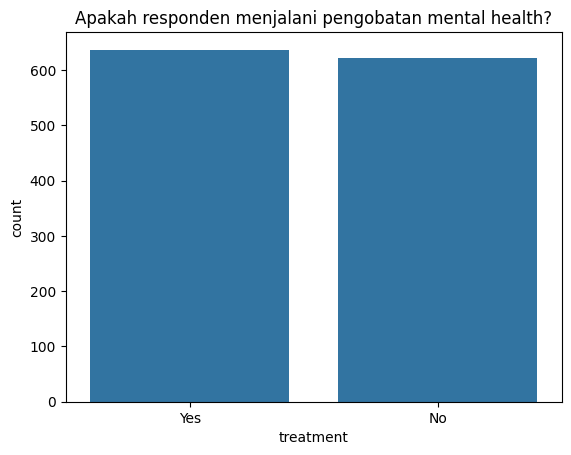

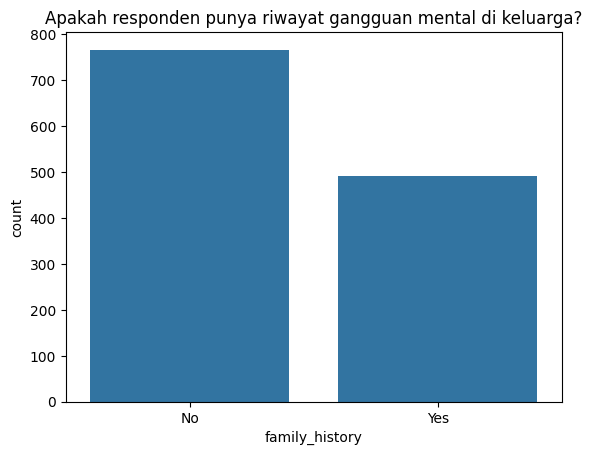

In [ ]:
# Distribusi responden berdasarkan treatment
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='treatment', data=df)
plt.title("Apakah responden menjalani pengobatan mental health?")
plt.show()

# Distribusi berdasarkan family history
sns.countplot(x='family_history', data=df)
plt.title("Apakah responden punya riwayat gangguan mental di keluarga?")
plt.show()


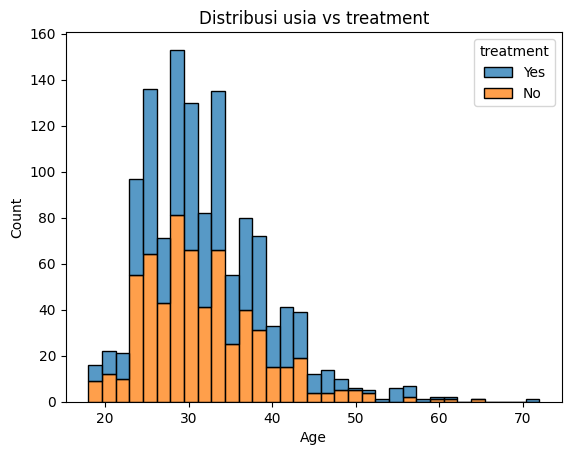

In [ ]:
# Bersihkan data umur yang aneh (misal di bawah 15 atau di atas 100)
df = df[(df['Age'] >= 15) & (df['Age'] <= 100)]

sns.histplot(data=df, x='Age', hue='treatment', multiple='stack')
plt.title("Distribusi usia vs treatment")
plt.show()


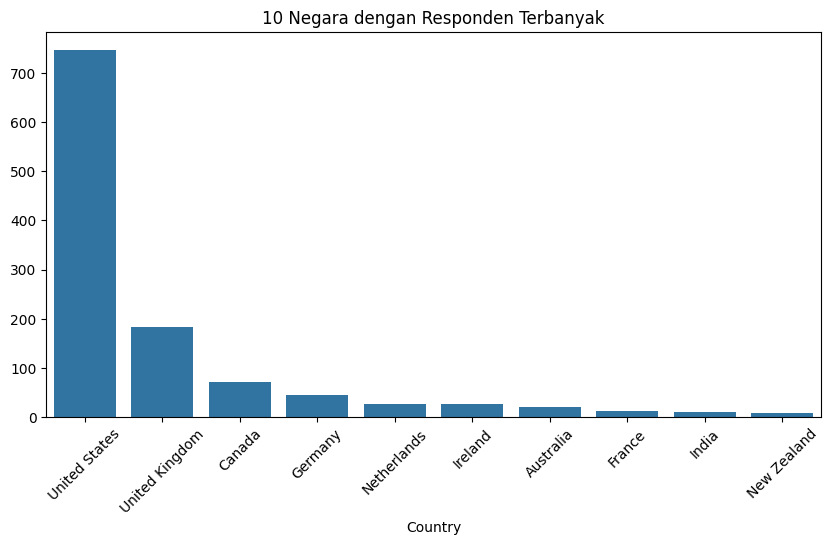

In [ ]:
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("10 Negara dengan Responden Terbanyak")
plt.xticks(rotation=45)
plt.show()


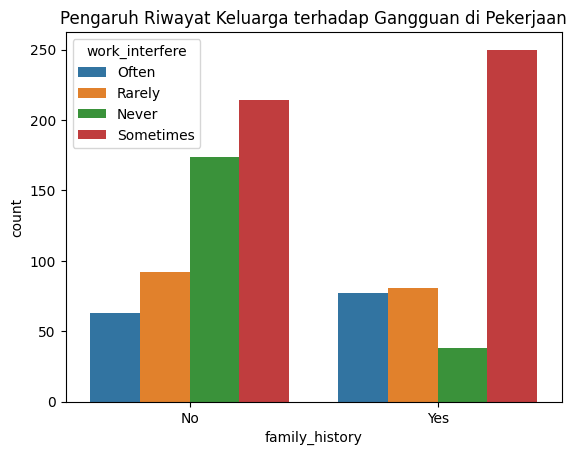

In [ ]:
sns.countplot(x='family_history', hue='work_interfere', data=df)
plt.title("Pengaruh Riwayat Keluarga terhadap Gangguan di Pekerjaan")
plt.show()


In [ ]:
!pip install langchain_community replicate

from langchain_community.llms import Replicate
import os
from google.colab import userdata

# Ambil token dari Colab Secrets
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Setup model Granite
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
    model=model,
    replicate_api_token=api_token,
)

print("Environment ready — IBM Granite connected!")

Environment ready — IBM Granite connected!


In [ ]:
# Step 5: Analisis insight menggunakan IBM Granite
import json

# Ambil sample data sebagai konteks untuk dikirim ke model
sample_data = df.sample(10).to_dict(orient="records")

prompt = f"""
Kamu adalah analis data kesehatan mental.
Berdasarkan data berikut (contoh 10 baris pertama):

{json.dumps(sample_data, indent=2)}

1. Analisis pola umum yang terlihat dari data tersebut.
2. Sebutkan faktor-faktor utama yang paling mempengaruhi seseorang mencari pengobatan mental.
3. Buat insight singkat dalam bentuk poin.
4. Prediksi tren umum tentang kondisi mental health pekerja teknologi (berdasarkan pola dari data ini).
"""

# Jalankan model Granite
insight = output.invoke(prompt)
print(insight)

1. **General Patterns Observed:**
   - The majority of the individuals are male (7 out of 10), with ages ranging from 23 to 34.
   - Most individuals reside in the United States (6 out of 10).
   - There is a mix of treatment-seeking (6 "Yes" and 4 "No") and work interference (ranging from "Never" to "Often").
   - Remote work is common among those who live in the US, with 5 out of 6 US-based individuals having remote work options.
   - Family history of mental health issues is reported in 3 cases, all of whom sought treatment.
   - Age 30 appears twice, and age 29 also appears twice, suggesting potential subgroups within this dataset.

2. **Key Factors Influencing Treatment-Seeking Behavior:**
   - **Gender:** Men seem more likely to seek treatment (5 out of 7 males sought treatment vs. 1 out of 3 females).
   - **Country:** Individuals from the United States are more inclined to seek treatment (5 out of 6 US-based individuals sought treatment).
   - **Age:** While not definitive due 

In [ ]:
# Minta Granite melanjutkan analisis yang terpotong
continue_prompt = """
Lanjutkan dari analisis sebelumnya yang berhenti di bagian nomor 4.
Tuliskan bagian 4 lengkap dengan prediksi tren umum tentang kondisi mental health di industri teknologi.
Gunakan format poin-poin dan bahas juga faktor pekerjaan jarak jauh, usia muda, dan budaya kerja teknologi.
"""

continuation = output.invoke(continue_prompt)
print(continuation)

Bagian 4: Prediksi Tren Umum Kondisi Kesehatan Mental di Industri Teknologi

1. **Peningkatan Stres dan Kekonflik dengan Jadwal Kerja Jarak Jauh**
   - Dengan meningkatnya tren kerja dari rumah, mungkin meningkat juga tingkat stres akibat batas waktu yang tidak jelas, overworking, dan kesulitan memisahkan ruang kerja dan pribadi.
   - Prediksi: Polisi kerja lebih lanjut yang mengakui keterbatasan energi dan mendorong waktu kerja yang lebih seimbang.

2. **Masalah Kesehatan Mental Usia Muda**
   - Generasi muda yang lebih tingkat berkontribusi dalam industri teknologi mungkin mengalami tingginya kesulitan mental akibat tekanan untuk berprestasi, perasaan tidak cukup, dan cabaran dalam mencapai kesuksesan.
   - Prediksi: Peningkatan kepedulian dan program dukungan khusus untuk karyawan muda, termasuk pelatihan mindfulness dan pengajaran keterampilan soft.

3. **Budaya Kerja yang Meningkatkan Isolasi dan Kekurangan Interaksi Sosial**
   - Kecerdasan teknologi yang meningkatkan kerja virtu

In [ ]:
# Step 6: Prediksi otomatis (AI prediction)
import json

new_person = {
    "Age": 28,
    "Gender": "Male",
    "Country": "United States",
    "family_history": "Yes",
    "work_interfere": "Often",
    "remote_work": "Yes"
}

prompt_predict = f"""
Kamu adalah analis AI yang memprediksi kemungkinan seseorang membutuhkan pengobatan kesehatan mental.
Berdasarkan profil berikut:

{json.dumps(new_person, indent=2)}

1. Jelaskan secara singkat faktor risiko yang dimiliki individu ini.
2. Prediksi apakah orang ini berkemungkinan "Perlu Treatment" atau "Tidak Perlu Treatment".
3. Jelaskan alasan di balik prediksi tersebut dengan bahasa yang mudah dipahami.
"""

prediction = output.invoke(prompt_predict)
print(prediction)

1. **Faktor Risiko:**

   - **Usia:** Usia 28 tahun mungkin tidak mewakili risiko tinggi secara umur, tetapi ini masih termasuk dalam kategori usia yang mungkin memiliki tekanan psikologis berbeda dengan usia lainnya.

   - **Jenis Kelamin:** Meskipun tidak ada faktor risiko unik yang disebabkan oleh jenis kelamin, statistik menunjukkan perbedaan dalam manifestasi masalah kesehatan mental antara pria dan wanita.

   - **Negara:** Sebagai warga negara Amerika Serikat, individu mungkin terkena tekanan sosial, ekonomi, atau kebimbangan kesehatan mental yang umum di negara ini.

   - **Riwayat Keluarga:** Riwayat positif (ya) terhadap penyakit mental dalam keluarga merupakan faktor risiko signifikan, menunjukkan predisposi yang genetik atau lingkungan yang sama.

   - **Kerja yang Mengganggu:** Individu mengatakan bahwa kerja seringkalan mengganggu mentalnya, yang dapat menunjukkan stres kerja, burnout, atau gangguan konflik kerja-hidup.

   - **Kerja Remote:** Mengelami pekerjaan di rumah

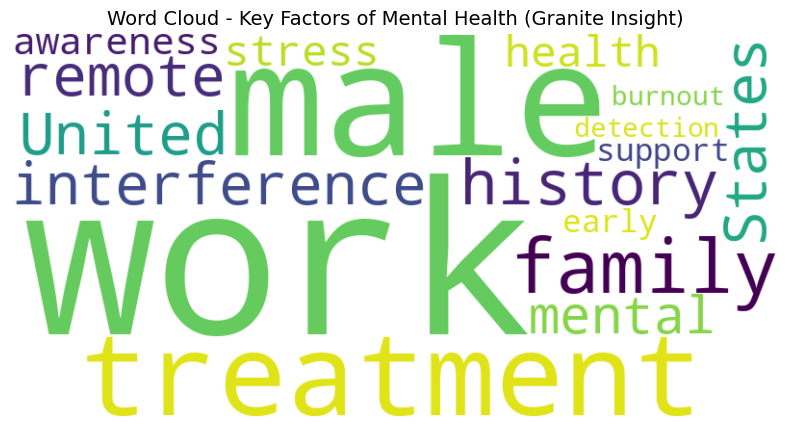

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = """
male, treatment, family history, work interference, remote work, United States,
mental health, stress, awareness, support, early detection, burnout
"""

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Key Factors of Mental Health (Granite Insight)", fontsize=14)
plt.show()